# Explore Features

This notebook looks at different features possible for training.

In [108]:
feature_invert = True

In [25]:
import config

import time
from lxml import etree
import os
import pandas as pd
import cv2 as cv
import numpy as np
from glob import glob
from PIL import Image
import spacy
nlp = spacy.load("en_core_web_sm")
import matplotlib.pyplot as plt

from feature_generation_utils import TAG_LIST, POS_LIST, DEP_LIST

from annotation_utils import get_all_ocr_files, collect_ocr_process_results

In [109]:
background = 255
if feature_invert: background = 0

In [7]:
# let's get all of the ocr files
ocrFiles = get_all_ocr_files()
# get important quantities from these files
print('retreiving OCR data, this can take a moment...')
ws, paragraphs, squares, html, rotations = collect_ocr_process_results(ocrFiles)
# create dataframe
df = pd.DataFrame({'ws':ws, 'paragraphs':paragraphs, 'squares':squares, 
                   'hocr':html, 'rotation':rotations})#, 'pdfwords':pdfwords})
df = df.drop_duplicates(subset='ws')
dfAll = df.set_index('ws').copy()

# get annotations
imgDirAnn = config.save_binary_dir + config.ann_name + str(int(config.IMAGE_H)) + 'x' + str(int(config.IMAGE_W))  + '_ann/'
# get all annotations
annotations = glob(imgDirAnn+'*.xml')

retreiving OCR data, this can take a moment...
--- OCR retrieval: on 0 of 5515
--- OCR retrieval: on 1000 of 5515
--- OCR retrieval: on 2000 of 5515
--- OCR retrieval: on 3000 of 5515
--- OCR retrieval: on 4000 of 5515
--- OCR retrieval: on 5000 of 5515


You can pick your own, or choose a random index to look at features with:

In [247]:
iRandom = np.random.randint(0,len(annotations),1)[0]
iRandom = 2105
iRandom

2105

Read in image to scale for all features:

In [248]:
fname = annotations[iRandom].split('/')[-1].split('.xml')[0]
imgResize = np.zeros([config.IMAGE_H,config.IMAGE_W])
imgResize[:,:] = 255

In [249]:
df = dfAll.loc[fname+'.jpeg']
df

paragraphs    [(902, 214, 786, 37), (902, 214, 786, 37), (90...
squares       [[[506, 1871], [2098, 1871], [2098, 2909], [50...
hocr          <?xml version="1.0" encoding="UTF-8"?>\n<!DOCT...
rotation      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 1995ApJ___447__378M_p7.jpeg, dtype: object

In [250]:
# bunch of stuff for getting OCR stuff --- this could be cleaned up
img_resize = (config.IMAGE_H,config.IMAGE_W)
#maxTag = 150
maxTag = 125 # max number of "color" band

# options for angles
angles = np.array([0, 90, 180, 270]) #options
steps = round(256./len(angles))

In [251]:
###### LINE CALCS #####
h = df['hocr']

fontshere = []; fontsizeshere = [] # fontsize
decendershere = [] # x_decenders
ascendershere = [] # x_ascenders
anglesshere = [] # text angles
nameSpace = ''
for l in h.split('\n'):
    if 'xmlns' in l:
        nameSpace = l.split('xmlns="')[1].split('"')[0]
        break
ns = {'tei': nameSpace}
tree = etree.fromstring(h.encode())
lines = tree.xpath("//tei:span[@class='ocr_line']/@title", namespaces=ns)
fonts = []
bboxes = []
confs = []
for l in lines:
    x = l.split(';') # each entry
    for y in x:
        if 'x_size' in y: # this is the one that is fontsize
            z = y.strip()
            fontsizeshere.append(float(z.split(' ')[-1]))
            fontshere.append(float(z.split(' ')[-1]))
        elif 'bbox' in y:
            z = y.strip()
            arr=y.split()
            b = np.array(arr[1:]).astype('int')
            bboxes.append( b )
        elif 'x_descenders' in y: # this is the one that is fontsize
            z = y.strip()
            decendershere.append(float(z.split(' ')[-1]))
        elif 'x_ascenders' in y: # this is the one that is fontsize
            z = y.strip()
            ascendershere.append(float(z.split(' ')[-1]))    # now, normalize by page
        elif 'textangle' in y: # this is the one that is fontsize
            z = y.strip()
            anglesshere.append(float(z.split(' ')[-1])) 

###### WORD CALCS #####
bboxesw = []
lines = tree.xpath("//tei:span[@class='ocrx_word']/@title", namespaces=ns)
text = tree.xpath("//tei:span[@class='ocrx_word']/text()", namespaces=ns)

# percentage of what?
smax = 0.0; lmax = 0.0; nmax = 0.0#; pmax = 0.0
for t,l in zip(text,lines):
    punc = 0
    # count thingies
    numbers = sum(c.isdigit() for c in t)
    letters = sum(c.isalpha() for c in t)
    spaces  = sum(c.isspace() for c in t)   
    #punc  = sum(c.isspace() for c in t)   
    if spaces > smax: smax = spaces
    if numbers > nmax: nmax = numbers
    if letters > lmax: lmax = letters
    if (numbers==0) and (letters==0) and (spaces==0):
        #print(t)
        punc = 1
    x = l.split(';') # each entry
    for y in x:
        if 'bbox' in y:
            z = y.strip()
            arr=y.split()
            b = np.array(arr[1:]).astype('int')
            bboxesw.append( (b, numbers, letters, spaces, punc ) ) 

bboxesw_conf = []
for i,word in enumerate(tree.xpath("//tei:span[@class='ocrx_word']", namespaces=ns)):
    myangle = word.xpath("../@title", namespaces=ns) # this should be line tag
    par = word.xpath("./@title", namespaces=ns)[0]
    bb = np.array(par.split(';')[0].split(' ')[1:]).astype('int').tolist()
    c = int(par.split('x_wconf')[-1])
    t = word.xpath("./text()",namespaces=ns)[0]
    if len(myangle) > 1:
        print('HAVE TOO MANY PARENTS')
    if 'textangle' in myangle[0]:
        # grab text angle
        textangle = float(myangle[0].split('textangle')[1].split(';')[0])
    else:
        textangle = 0.0    
    bboxesw_conf.append((bb,t,c,textangle))  

##### CAREA CALCS #####
bbox_carea = []
lines = tree.xpath("//tei:div[@class='ocr_carea']/@title", namespaces=ns)
for l in lines:
    x = l.split(' ')
    b = np.array(x[1:]).astype('int')
    #b[1]:b[3], b[0]:b[2]
    area = (b[3]-b[1])*(b[2]-b[0])
    bbox_carea.append((b,area))

#### PARAGRAPH CALCS #####
bbox_par = []
lines = tree.xpath("//tei:p[@class='ocr_par']/@title", namespaces=ns)
langs = tree.xpath("//tei:p[@class='ocr_par']/@lang", namespaces=ns)
for l,la in zip(lines,langs):
    x = l.split(' ')
    b = np.array(x[1:]).astype('int')
    area = (b[3]-b[1])*(b[2]-b[0])
    bbox_par.append((b,area,la))

##### Spacy CALCS #####
docText = ""
for b,t,c,ang in bboxesw_conf:
    docText += t + ' '
doc = nlp(docText)
pos = []; tags = []; deps = []; is_alpha = []; is_stop = []
for token in doc:
    pos.append(token.pos_)
    tags.append(token.tag_)
    deps.append(token.dep_)
    is_alpha.append(token.is_alpha)
    is_stop.append(token.is_stop)
# put back into words -- OCR doesn't match Spacy tokens
stexts = []
for b,t,c,ang in bboxesw_conf:
    stexts.append(t)    
wh = []; ph = []; th = []; dh = []
bbox_spacy = []
for token,p,t,d,a,s in zip(doc,pos,tags,deps,is_alpha,is_stop):
    wh.append(token.text); ph.append(p); th.append(t); dh.append(d)
    if token.whitespace_ != '': # new word
        # now here we want to *roughly* cut up each word into its different parts
        # and save these as boxes
        # first, find index of word to match box
        indw = stexts.index(''.join(wh))
        bb, w, c, ang = bboxesw_conf[indw]
        if len(ph) > 1: # multi-part spacy word
            if ang == 0 or ang == 180: # not rotated -- split along x
                fx = []
                for w1 in wh:
                    fx.append(len(w1)/len(w)) # fraction of word of this tag
                # split boxes, first one
                x1 = bb[0]; y1 = bb[1]; h1 = bb[3]-bb[1]
                w1 = round((bb[2]-bb[0])*fx[0])
                bbox_spacy.append((x1,y1,w1,h1,
                                   POS_LIST.index(ph[0]),
                                   TAG_LIST.index(th[0]),
                                   DEP_LIST.index(dh[0])))
                for iif in range(1,len(fx)):
                    x1 += w1 # start and other's end
                    w1 = round((bb[2]-bb[0])*fx[iif])
                    bbox_spacy.append((x1,y1,w1,h1,
                                       POS_LIST.index(ph[iif]),
                                       TAG_LIST.index(th[iif]),
                                       DEP_LIST.index(dh[iif])))
            elif ang == 90 or ang == 270: # rotated
                #if ang == 180: print(df['ws'].values[iw], w)
                fy = []
                for w1 in wh:
                    fy.append(len(w1)/len(w)) # fraction of word of this tag
                # split boxes, first one
                x1 = bb[0]; y1 = bb[1]; w1 = bb[2]-bb[0]
                h1 = round((bb[3]-bb[1])*fy[0])
                bbox_spacy.append((x1,y1,w1,h1,
                                   POS_LIST.index(ph[0]),
                                   TAG_LIST.index(th[0]),
                                   DEP_LIST.index(dh[0])))
                for iif in range(1,len(fy)):
                    y1 += h1 # start and other's end
                    h1 = round((bb[3]-bb[1])*fy[iif])
                    bbox_spacy.append((x1,y1,w1,h1,POS_LIST.index(ph[iif]),
                                       TAG_LIST.index(th[iif]),
                                       DEP_LIST.index(dh[iif])))
            else:
                print('weird rotation')
                print(ang, w, df.name)
                #import sys; sys.exit()
        else: # just one word
            bbox_spacy.append((bb[0],bb[1],bb[2]-bb[0],bb[3]-bb[1], 
                                POS_LIST.index(ph[0]),
                                   TAG_LIST.index(th[0]),
                                   DEP_LIST.index(dh[0])))
        wh = []; ph = []; th=[]; dh=[]

In [255]:
#print(h)

In [253]:
img = np.array(Image.open(config.images_jpeg_dir+fname+'.jpeg').convert('L'))
img2 = np.array(Image.open(config.images_jpeg_dir+fname+'.jpeg').convert('P'))
if feature_invert: img = 255-img; img2 = 255-img2

## Grayscale

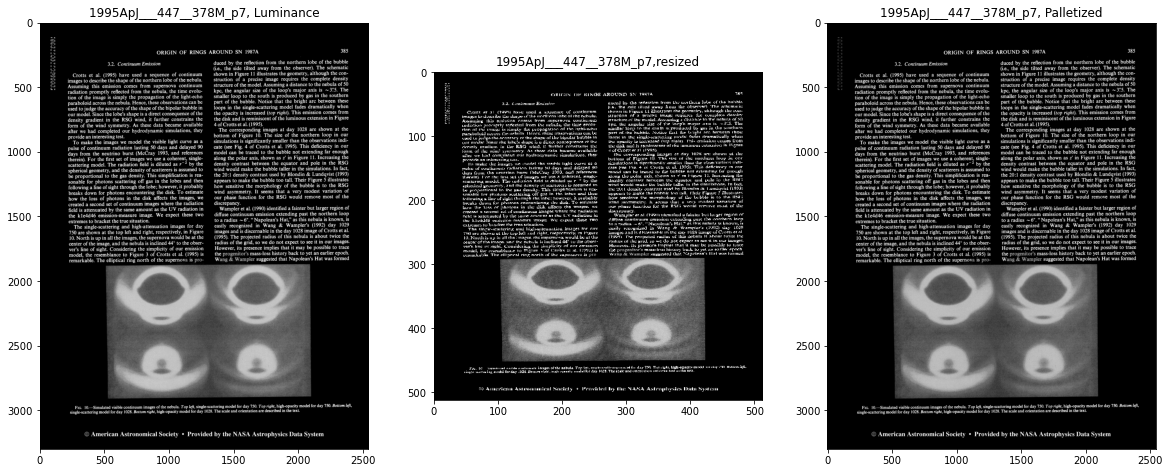

In [254]:
plt.close('all')
imgOrig = img.copy()
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(img, cmap='gray')
ax[0].set_title(fname+ ', Luminance')


# for YOLO size
imgGray = cv.resize(np.array(img).astype(np.uint8),
                    (config.IMAGE_H,config.IMAGE_W),
                    fx=0, fy=0, interpolation = cv.INTER_NEAREST)
ax[1].imshow(imgGray,cmap='gray')
ax[1].set_title(fname+',resized')

ax[2].imshow(img2, cmap='gray')
ax[2].set_title(fname + ', Palletized')

plt.show()

## Fontsize

In [218]:
# fontshere.min(), fontshere.max()

# fontshere[fontshere > 3*np.std(fontshere)]

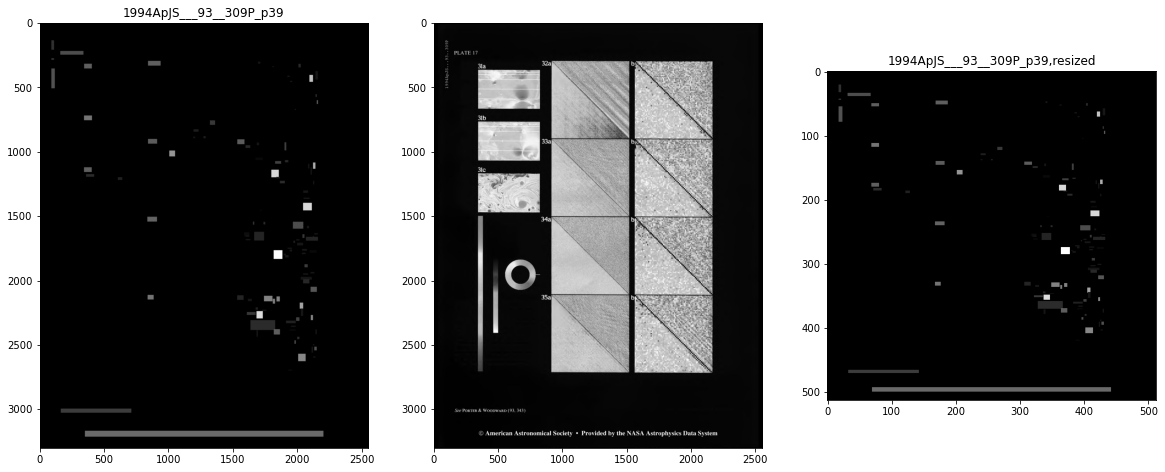

In [234]:
fontshere = np.array(fontshere)
fontshere -= np.median(fontshere)
# remove outliers
fontshere[np.abs(fontshere) > 5*np.std(fontshere)] = 0.0
#fontshere /= np.std(fontshere)

if len(fontshere) > 1:
    if fontshere.max() != fontshere.min():
        scales_unscaled = (fontshere-fontshere.min())/(fontshere.max()-fontshere.min())
    else:
        scales_unscaled = fontshere.copy()
        scales_unscaled[:] = background
else:
    scales_unscaled = [np.array(background)]
# get img and plot
imgOrig = img.copy()
imgOrig[:,:] = background
# fill
for b,su in zip(bboxes,scales_unscaled):
    #imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(255-255*su))
    if feature_invert:
        imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(255*su))
    else:
        imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(255-255*su))

imgout = cv.resize(np.array(imgOrig).astype(np.uint8),img_resize,fx=0, fy=0, interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)

ax[1].imshow(img,cmap='gray')

# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')


plt.show()

## Carea Boxes

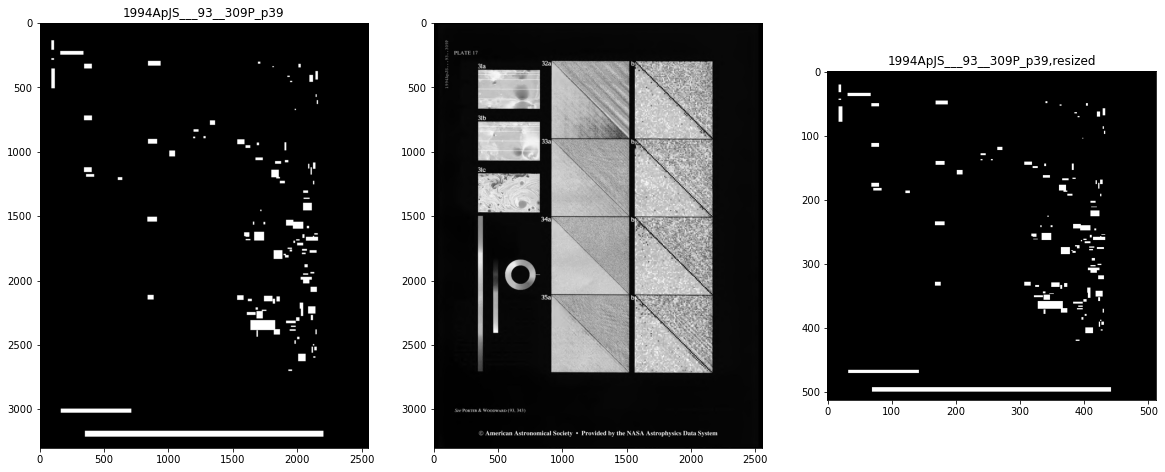

In [220]:
imgOrig = img.copy()
imgOrig[:,:] = background
for b,a in bbox_carea:
    imgOrig[b[1]:b[3], b[0]:b[2]] = 255-background  
imgout = cv.resize(np.array(imgOrig).astype(np.uint8),img_resize,fx=0, fy=0, interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)

ax[1].imshow(img,cmap='gray')

# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

## Paragraph Boxes

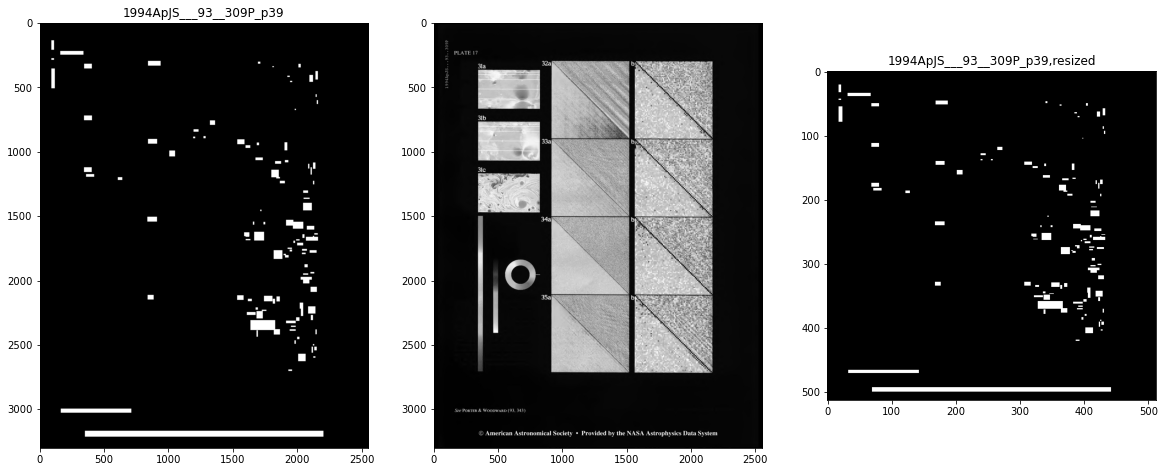

In [221]:
imgOrig = img.copy()
imgOrig[:,:] = background
for b,a,l in bbox_par:
    imgOrig[b[1]:b[3], b[0]:b[2]] = 255-background    
imgout = cv.resize(np.array(imgOrig).astype(np.uint8),
                                 img_resize,fx=0, fy=0, 
                                 interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)

ax[1].imshow(img,cmap='gray')

# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

## Fraction of Numbers in a Word

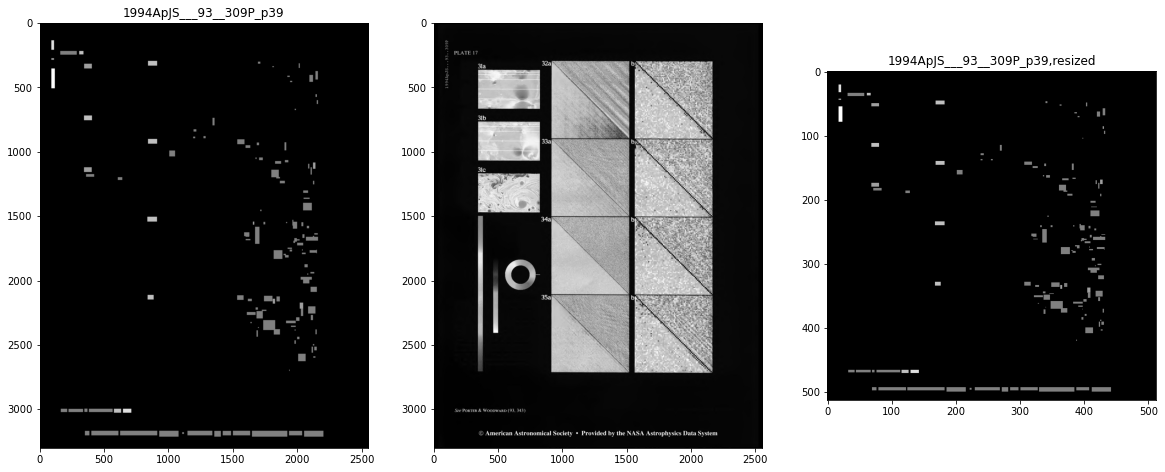

In [222]:
if nmax == 0: nmax = 1.0
imgOrig = img.copy()
imgOrig[:,:] = background
for b,n,l,s,p in bboxesw: # numbers, letters, spaces, punc
    #imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(n/nmax*maxTag))
    if feature_invert:
        imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(n/nmax*maxTag+maxTag)) # always be increasing, just change where we start
    else:
        imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(n/nmax*maxTag))

imgout = cv.resize(np.array(imgOrig).astype(np.uint8),
                                 img_resize,fx=0, fy=0, 
                                 interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)

ax[1].imshow(img,cmap='gray')

# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

## Fraction of Letters in a Word

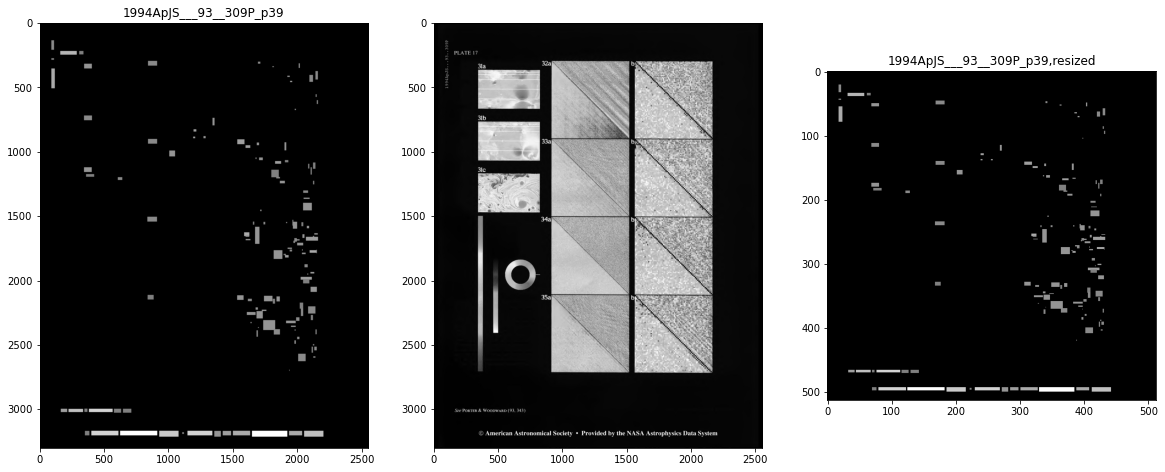

In [223]:
imgOrig = img.copy()
imgOrig[:,:] = background
if lmax == 0: lmax = 1.0
for b,n,l,s,p in bboxesw: # numbers, letters, spaces, punc
    #imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(l/lmax*maxTag))
    if feature_invert:
        imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(l/lmax*maxTag+maxTag))
    else:
        imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(l/lmax*maxTag))

imgout = cv.resize(np.array(imgOrig).astype(np.uint8),
                                 img_resize,fx=0, fy=0, 
                                 interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)

ax[1].imshow(img,cmap='gray')

# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

## Punctuation

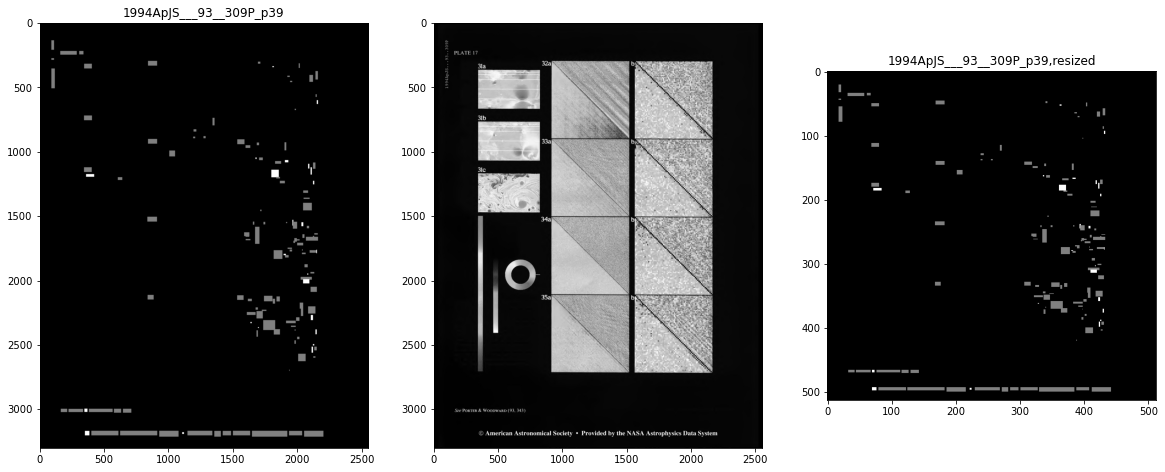

In [224]:
imgOrig = img.copy()
imgOrig[:,:] = background
for b,n,l,s,p in bboxesw: # numbers, letters, spaces, punc
    #imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(p*maxTag))
    if feature_invert:
        imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(p*maxTag+maxTag))
    else:
        imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(p*maxTag))

imgout = cv.resize(np.array(imgOrig).astype(np.uint8),img_resize,fx=0, fy=0, interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)
ax[1].imshow(img,cmap='gray')
# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

## X-Ascenders

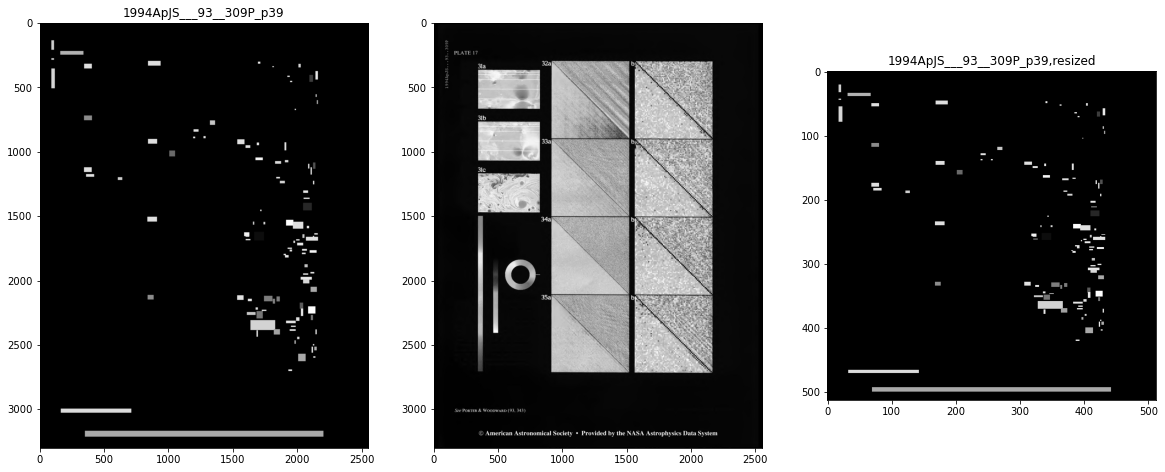

In [225]:
imgOrig = img.copy()
imgOrig[:,:] = 255
decendershere = np.array(decendershere)
med_dec = np.median(decendershere)
scales_decenders = (decendershere-med_dec) # around the median
min_dec = scales_decenders.min(); max_dec = scales_decenders.max()
if min_dec == max_dec: min_dec = 0; max_dec = 1
scales_decenders = (scales_decenders-min_dec)/(max_dec-min_dec) # reshift to start at 0
scales_decenders[scales_decenders<0] = 0
scales_decenders[scales_decenders>1] = 1
for b,s in zip(bboxes,scales_decenders):
    imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(s*255)) # x_ascenders should always be low colors   
if feature_invert: imgOrig = 255-imgOrig
imgout = cv.resize(np.array(imgOrig).astype(np.uint8),
                                 img_resize,fx=0, fy=0, 
                                 interpolation = cv.INTER_NEAREST)
## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)
ax[1].imshow(img,cmap='gray')
# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

In [226]:
#imgOrig.max(), imgOrig.min(), background

## X-Decenders

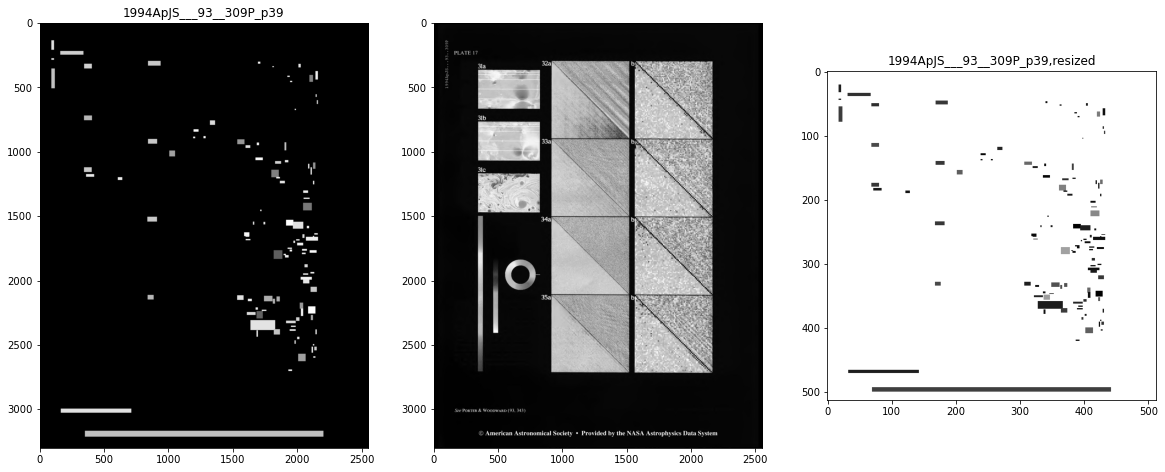

In [227]:
imgOrig = img.copy()
imgOrig[:,:] = 255
ascendershere = np.array(ascendershere)
ascendershere += np.median(ascendershere)
min_asc = ascendershere.min(); max_asc = ascendershere.max()
scales_ascenders = (ascendershere-min_asc)/(max_asc-min_asc)
scales_ascenders[scales_ascenders<0] = 0
scales_ascenders[scales_ascenders>1] = 1
for b,s in zip(bboxes,scales_ascenders):
    imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(s*255))    
imgout = cv.resize(np.array(imgOrig).astype(np.uint8),
                                 img_resize,fx=0, fy=0, 
                                 interpolation = cv.INTER_NEAREST)
if feature_invert: imgOrig = 255-imgOrig
## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)
ax[1].imshow(img,cmap='gray')
# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

## Text Angles

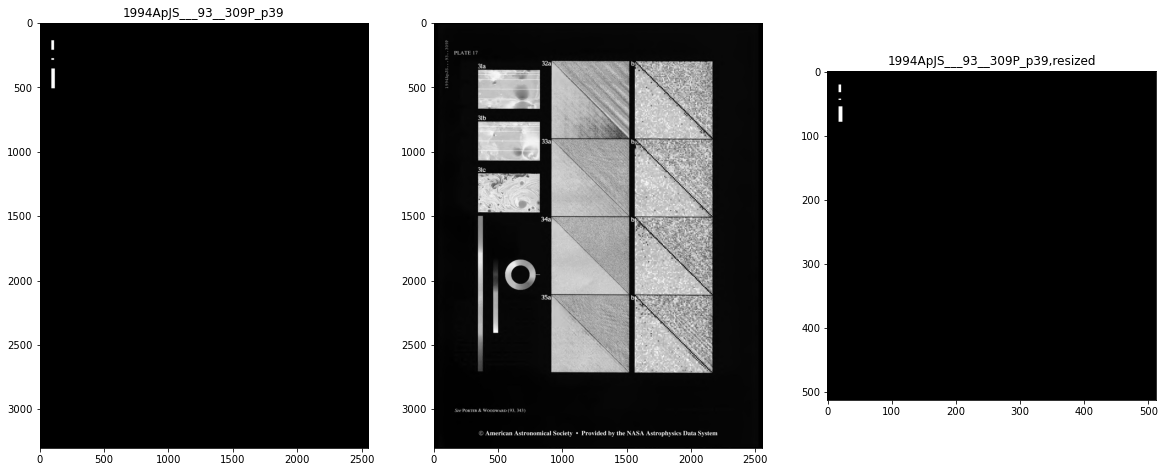

In [228]:
imgOrig = img.copy()
imgOrig[:,:] = background
for b,t,c,ang in bboxesw_conf:
    inda = np.where(ang == angles)[0][0]
    # angle 0 = "normal"
    imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(min([inda*steps,255])))
    if not feature_invert: 
        imgOrig[b[1]:b[3], b[0]:b[2]] = 255-imgOrig[b[1]:b[3], b[0]:b[2]]
imgout = cv.resize(np.array(imgOrig).astype(np.uint8),
                                 img_resize,fx=0, fy=0, 
                                 interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)
ax[1].imshow(img,cmap='gray')
# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

In [229]:
#np.unique(imgOrig)

## Word Confidences

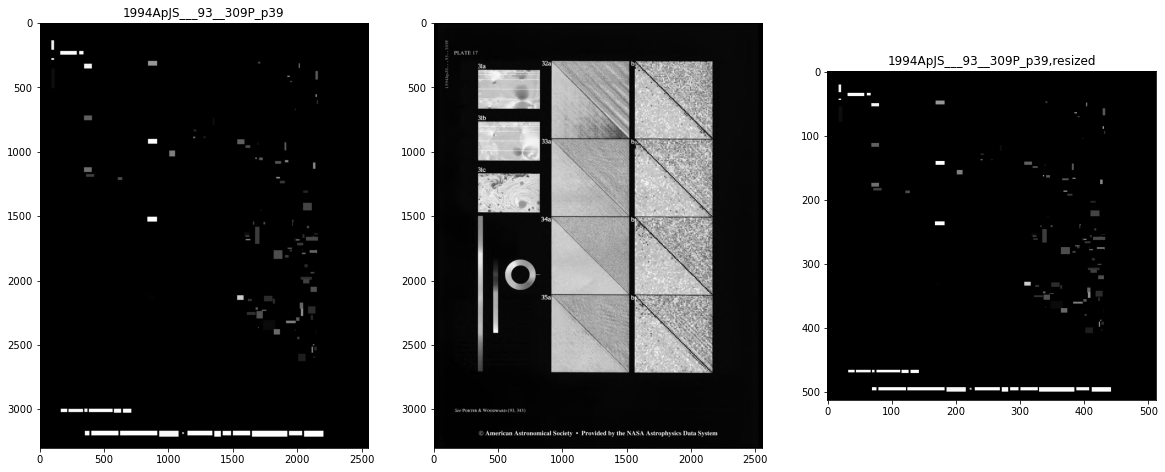

In [230]:
imgOrig = img.copy()
imgOrig[:,:] = background
for b,t,s,a in bboxesw_conf:
    # default is bad-conf closer to background
    if not feature_invert:
        imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(255-255*s/100.))
    else:
        imgOrig[b[1]:b[3], b[0]:b[2]] = int(round(255*s/100.))
imgout = cv.resize(np.array(imgOrig).astype(np.uint8),
                                 img_resize,fx=0, fy=0, 
                                 interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)
ax[1].imshow(img,cmap='gray')
# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

## Spacy POS

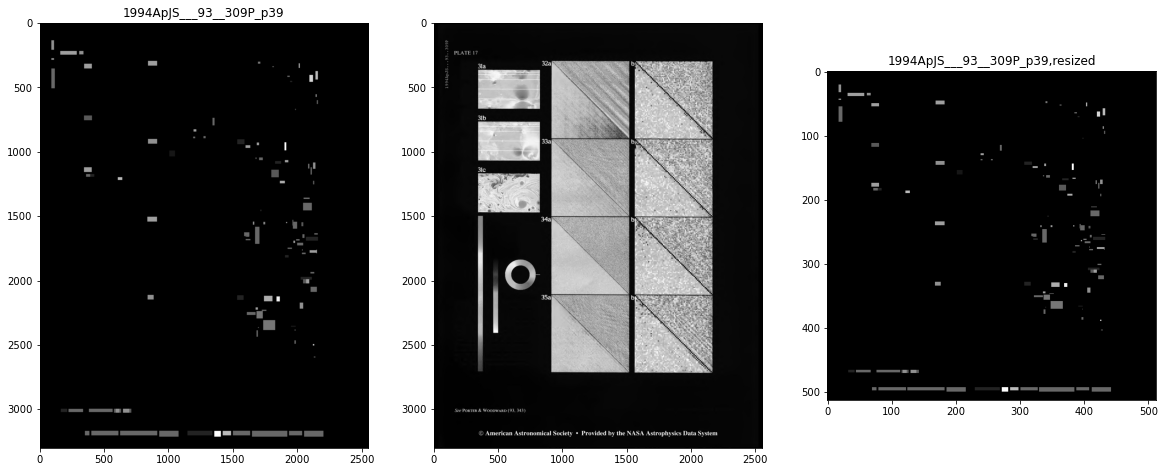

In [231]:
imgOrig = img.copy()
imgOrig[:,:] = background
for b in bbox_spacy: # ideally, these should each be a layer, but...
    imgOrig[b[1]:b[1]+b[3], b[0]:b[0]+b[2]] = b[4]*(255//len(POS_LIST))
    if feature_invert: 
        imgOrig[b[1]:b[1]+b[3], b[0]:b[0]+b[2]] = 255-imgOrig[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]
imgout = cv.resize(np.array(imgOrig).astype(np.uint8),
                                 img_resize,fx=0, fy=0, 
                                 interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)
ax[1].imshow(img,cmap='gray')
# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

## Spacy TAG

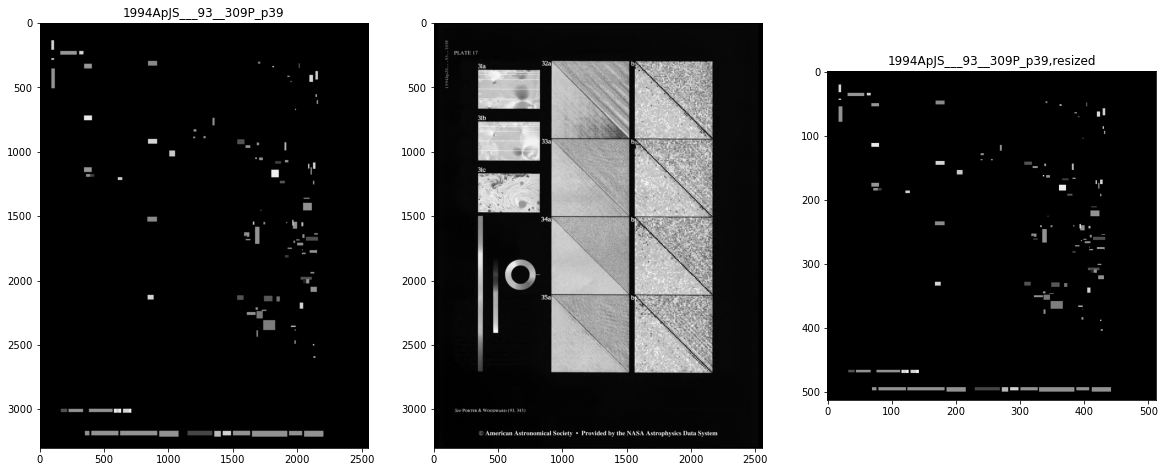

In [232]:
imgOrig = img.copy()
imgOrig[:,:] = background
for b in bbox_spacy:
    imgOrig[b[1]:b[1]+b[3], b[0]:b[0]+b[2]] = b[5]*(255//len(TAG_LIST))
    if feature_invert: 
        imgOrig[b[1]:b[1]+b[3], b[0]:b[0]+b[2]] = 255-imgOrig[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]
imgout = cv.resize(np.array(imgOrig).astype(np.uint8),
                                 img_resize,fx=0, fy=0, 
                                 interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)
ax[1].imshow(img,cmap='gray')
# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()

## Spacy DEP

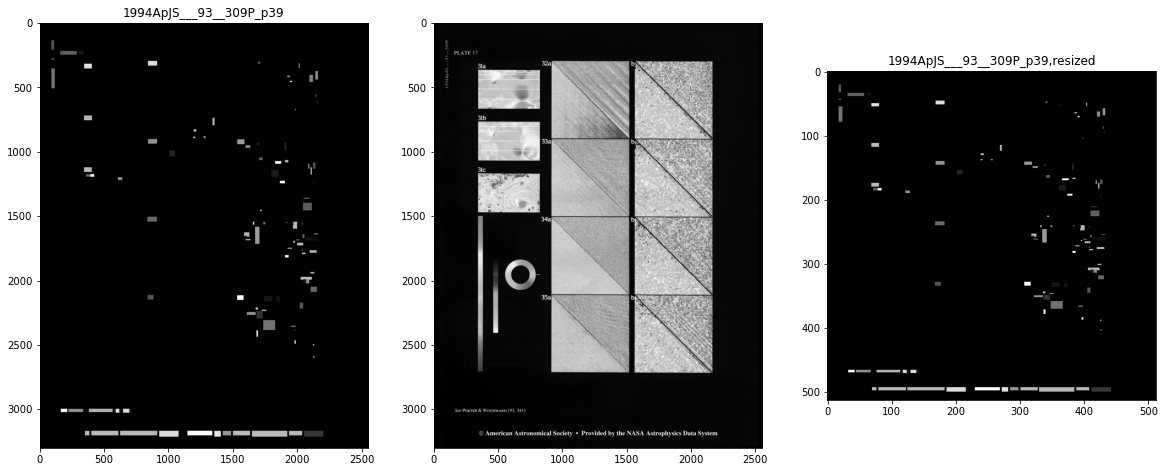

In [233]:
imgOrig = img.copy()
imgOrig[:,:] = background
for b in bbox_spacy:
    imgOrig[b[1]:b[1]+b[3], b[0]:b[0]+b[2]] = b[6]*(255/len(DEP_LIST))
    if feature_invert: 
        imgOrig[b[1]:b[1]+b[3], b[0]:b[0]+b[2]] = 255-imgOrig[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]
imgout = cv.resize(np.array(imgOrig).astype(np.uint8),
                                 img_resize,fx=0, fy=0, 
                                 interpolation = cv.INTER_NEAREST)

## plot
fig,ax=plt.subplots(1,3,figsize=(20,18))

ax[0].imshow(imgOrig, cmap='gray')
ax[0].set_title(fname)
ax[1].imshow(img,cmap='gray')
# for YOLO size
ax[2].imshow(imgout,cmap='gray')
ax[2].set_title(fname+',resized')

plt.show()